In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
# from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

# Misc.
import os
from pathlib import Path
import dill

import warnings
warnings.filterwarnings('ignore')

**Import and explore the dataset: COVID and Non-COVID Lung scanning images**

**Number of images: 2343**

In [2]:
import pathlib
data_dir  = Path('/Users/preethamvignesh/Downloads/cards_raw/')
data_dir = pathlib.Path(data_dir)

In [3]:
image_count = len(list(data_dir.glob('*/*.*')))
print(image_count)

2343


**Here is one sample logo**

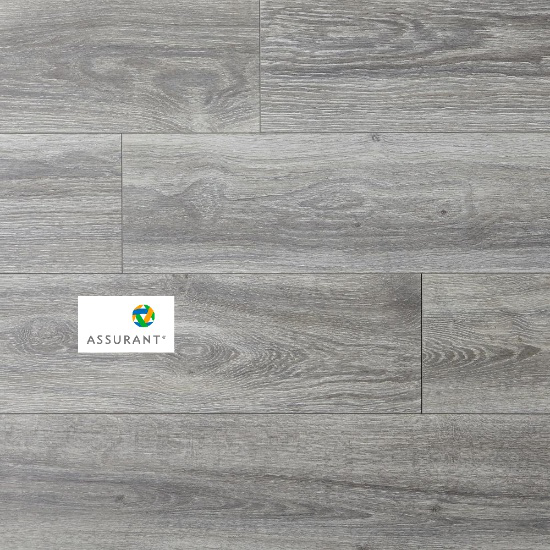

In [4]:
images = list(data_dir.glob('Assurant/*'))
PIL.Image.open(str(images[16]))

In [5]:
# Define some parameters for the loader:
batch_size = 32
img_height = 64
img_width = 64

In [6]:
#labels creation
# from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img 
# datagen = ImageDataGenerator(rescale=1. / 255) 
# generator_top = datagen.flow_from_directory(
#     data_dir,
#     target_size=(img_width, img_height),
#     batch_size=batch_size,
#     class_mode='categorical',
#     shuffle=False)
# # get the class labels for the training data, in the original order 
# train_labels = generator_top.classes 

It's good practice to use a validation split when developing your model. We will use 80% of the images for training, and 20% for validation.

Create a train generator and Validation generator


In [7]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2341 files belonging to 3 classes.
Using 1873 files for training.


In [8]:
# from sklearn.model_selection import train_test_split
# train_data,train_labels,test_data,test_labels=train_test_split(YOUR DATA,YOUR LABELS)
# convert the training labels to categorical vectors 
# from keras.utils.np_utils import to_categorical 
# num_classes = len(generator_top.class_indices) 
# train_labels = to_categorical(train_labels, num_classes=num_classes)
# train_labels

In [9]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2341 files belonging to 3 classes.
Using 468 files for validation.


You can find the class names in the class_names attribute on these datasets. These correspond to the directory names in alphabetical order.

In [10]:
class_names = train_ds.class_names
print(class_names)

['Assurant', 'Bluecross', 'Horizon']


**Visualize the data**

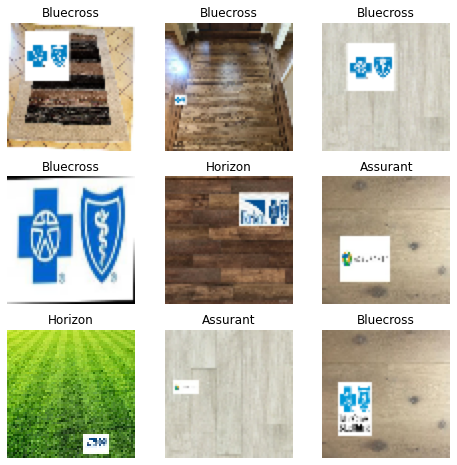

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

You will train a model using these datasets by passing them to model.fit in a moment. If you like, you can also manually iterate over the dataset and retrieve batches of images:

In [12]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 64, 64, 3)
(32,)


The image_batch is a tensor of the shape =(32, 64, 64,3) This is batch of 32 images of shape (64x64x3), (the last dimension 3 is refers to color channels RGB)

Configure the dataset for performance

We can yield data from disk without having I/O become blocking. The two important methods: Dataset.cache() and Dataset.Prefetch()

Dataset.cache(): keeps the images in memory after they're loaded off disk during the first epoch. Dataset.prefectch(): overlaps data preprocessing and model execution while training.


In [13]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(500).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Standardize the data

The RGB channel values are in the [0, 255] range. This is not ideal for a neural network; in general you should seek to make your input values small. Here, we will standardize values to be in the [0, 1] by using a Rescaling layer.


In [14]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

There are two ways to use this layer. You can apply it to the dataset by calling map:

In [17]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
# print(np.min(first_image), np.max(first_image)) 

Create the model

The model consists of three convolution blocks with a max pool layer in each of them. There's a fully connected layer with 128 units on top of it that is activated by a relu activation function. This model has not been tuned for high accuracy, the goal of this tutorial is to show a standard approach.


In [18]:
num_classes = 5

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(512, activation='relu'),
  layers.Dropout(0.2),
  layers.Dense(num_classes)
])

Compile the model

For this tutorial, choose the optimizers.Adam optimizer and losses.SparseCategoricalCrossentropy loss function. To view training and validation accuracy for each training epoch, pass the metrics argument.


In [19]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0

Train the model

In [20]:
train_ds,val_ds

(<PrefetchDataset shapes: ((None, 64, 64, 3), (None,)), types: (tf.float32, tf.int32)>,
 <PrefetchDataset shapes: ((None, 64, 64, 3), (None,)), types: (tf.float32, tf.int32)>)

In [21]:
epochs=10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/10
59/59 [==============================] - 9s 141ms/step - loss: 1.1979 - accuracy: 0.3232 - val_loss: 0.8731 - val_accuracy: 0.5812
Epoch 2/10
59/59 [==============================] - 7s 111ms/step - loss: 0.8351 - accuracy: 0.6054 - val_loss: 0.5397 - val_accuracy: 0.7885
Epoch 3/10
59/59 [==============================] - 6s 106ms/step - loss: 0.5098 - accuracy: 0.7977 - val_loss: 0.2750 - val_accuracy: 0.8932
Epoch 4/10
59/59 [==============================] - 6s 109ms/step - loss: 0.2759 - accuracy: 0.8983 - val_loss: 0.3814 - val_accuracy: 0.8654
Epoch 5/10
59/59 [==============================] - 6s 103ms/step - loss: 0.2920 - accuracy: 0.8874 - val_loss: 0.2106 - val_accuracy: 0.9167
Epoch 6/10
59/59 [==============================] - 6s 104ms/step - loss: 0.1640 - accuracy: 0.9356 - val_loss: 0.1482 - val_accuracy: 0.9487
Epoch 7/10
59/59 [==============================] - 6s 109ms/step - loss: 0.1309 - accuracy: 0.9455 - val_loss: 0.1427 - val_accuracy: 0.9423
Epoch 

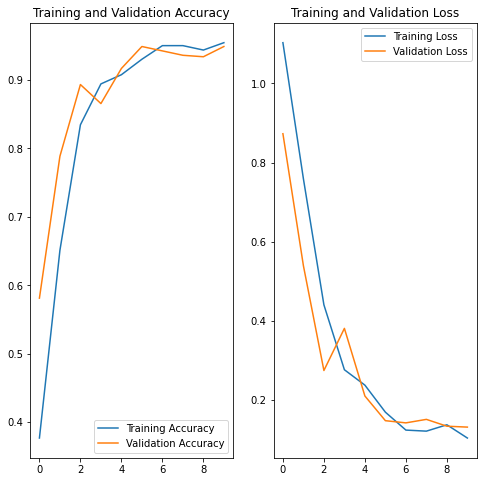

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [23]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

Let's visualize what a few augmented examples look like by applying data augmentation to the same image several times:

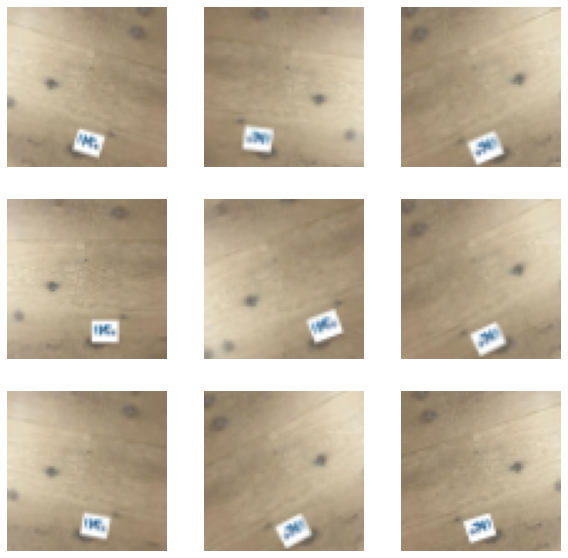

In [24]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

prediction for different Images

In [25]:
from sklearn.metrics import accuracy_score,confusion_matrix
test_labels_pred = model.predict(val_ds)
test_labels_pred.shape

(468, 5)

This image most likely belongs to Bluecross with a 100.00 percent confidence.


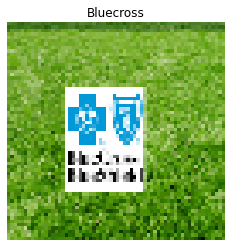

This image most likely belongs to Bluecross with a 100.00 percent confidence.


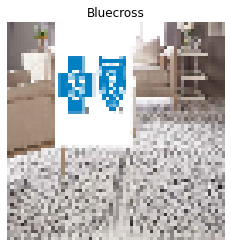

This image most likely belongs to Bluecross with a 99.96 percent confidence.


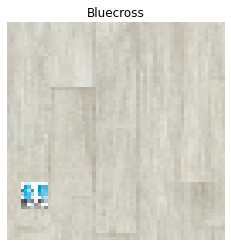

This image most likely belongs to Bluecross with a 100.00 percent confidence.


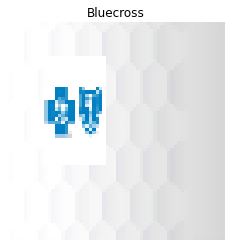

This image most likely belongs to Horizon with a 98.93 percent confidence.


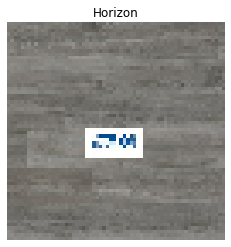

This image most likely belongs to Bluecross with a 54.31 percent confidence.


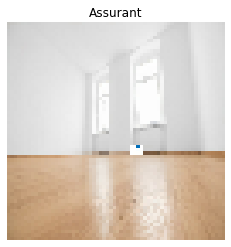

This image most likely belongs to Assurant with a 100.00 percent confidence.


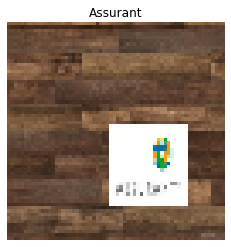

This image most likely belongs to Bluecross with a 100.00 percent confidence.


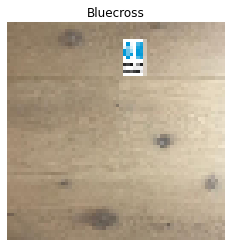

This image most likely belongs to Bluecross with a 100.00 percent confidence.


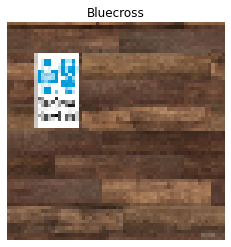

This image most likely belongs to Bluecross with a 100.00 percent confidence.


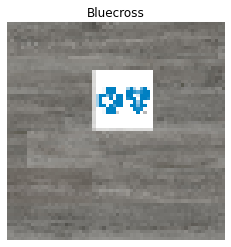

In [26]:
for images, labels in val_ds.take(1):
    for i in range(10,20):
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
        
        image = images[i]
        image1 = np.array(image).reshape((1,img_height,img_width,3))
        #print(image.shape,image1.shape)
        prediction = model.predict(image1)
        #print(prediction.shape)
        
        score = tf.nn.softmax(prediction[0])
        print(
            "This image most likely belongs to {} with a {:.2f} percent confidence."
            .format(class_names[np.argmax(score)], 100 * np.max(score)))
        plt.show()

Predtiction single image

This image most likely belongs to Horizon with a 99.62 percent confidence.


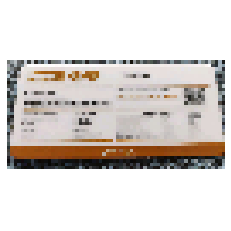

In [27]:
def predimg(timg):
    img = keras.preprocessing.image.load_img(timg, target_size=(img_height, img_width))
    plt.imshow(img, cmap=plt.cm.binary)
    plt.axis("off")

    image1 = np.array(img).reshape((1,img_height,img_width,3))
    #print(image.shape,image1.shape)
    prediction = model.predict(image1)
    #print(prediction.shape)

    score = tf.nn.softmax(prediction[0])
    print("This image most likely belongs to {} with a {:.2f} percent confidence."
          .format(class_names[np.argmax(score)], 100 * np.max(score)))
    plt.show()
    
    return

# timgg = "/Users/preethamvignesh/Downloads/cards_raw/Assurant/Assurant_3.jpg"
# timgg="/Users/preethamvignesh/Downloads/test1.jpg"
# timgg="/Users/preethamvignesh/Downloads/test2.png"
# timgg="/Users/preethamvignesh/Downloads/test3.jpg"
# timgg="/Users/preethamvignesh/Downloads/test4.png"
# timgg="/Users/preethamvignesh/Downloads/images1/test1.jpg"
timgg="/Users/preethamvignesh/Downloads/images1/horizon.jpg"
# timgg="/Users/preethamvignesh/Downloads/images1/card1.png"
predimg(timgg)